### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = '1vZDYqz6fqsL4nDe6XyF'

In [4]:
# Importing the Federal Reserve Economic Data "Personal Consumption Expenditures" variable.

data = quandl.get('FRED/PCE')

In [5]:
data.head(5)

,Value
Date,
1959-01-01,306.1
1959-02-01,309.6
1959-03-01,312.7
1959-04-01,312.2
1959-05-01,316.1


In [6]:
data.shape

(756, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

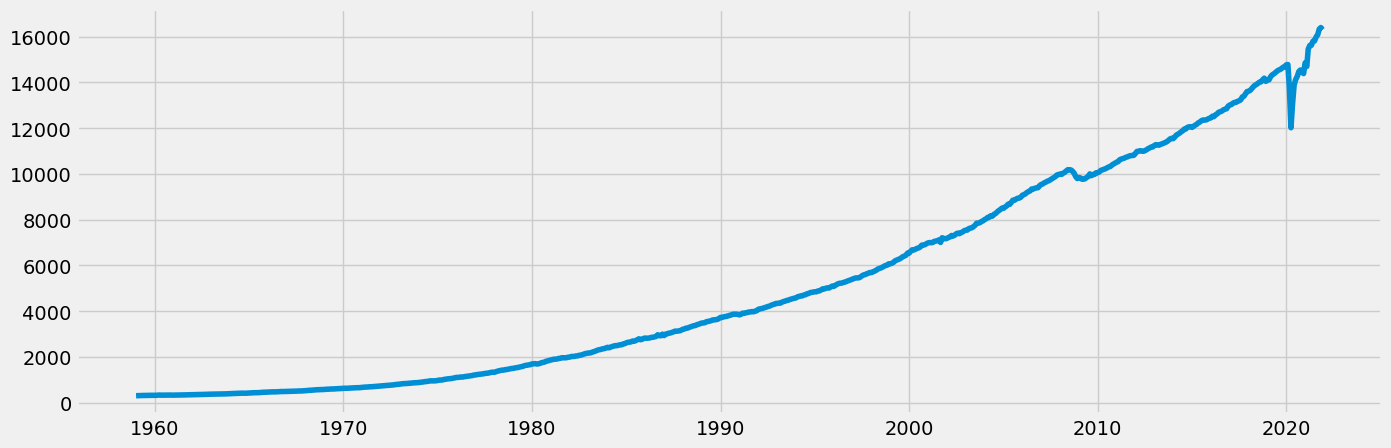

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1959-01-01,306.1
1,1959-02-01,309.6
2,1959-03-01,312.7
3,1959-04-01,312.2
4,1959-05-01,316.1


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2023-06-01')]

In [13]:
data_sub.shape

(504, 2)

In [14]:
data_sub.head()

,Date,Value
252,1980-01-01,1697.3
253,1980-02-01,1701.4
254,1980-03-01,1708.2
255,1980-04-01,1695.2
256,1980-05-01,1700.1


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,1697.3
1980-02-01,1701.4
1980-03-01,1708.2
1980-04-01,1695.2
1980-05-01,1700.1


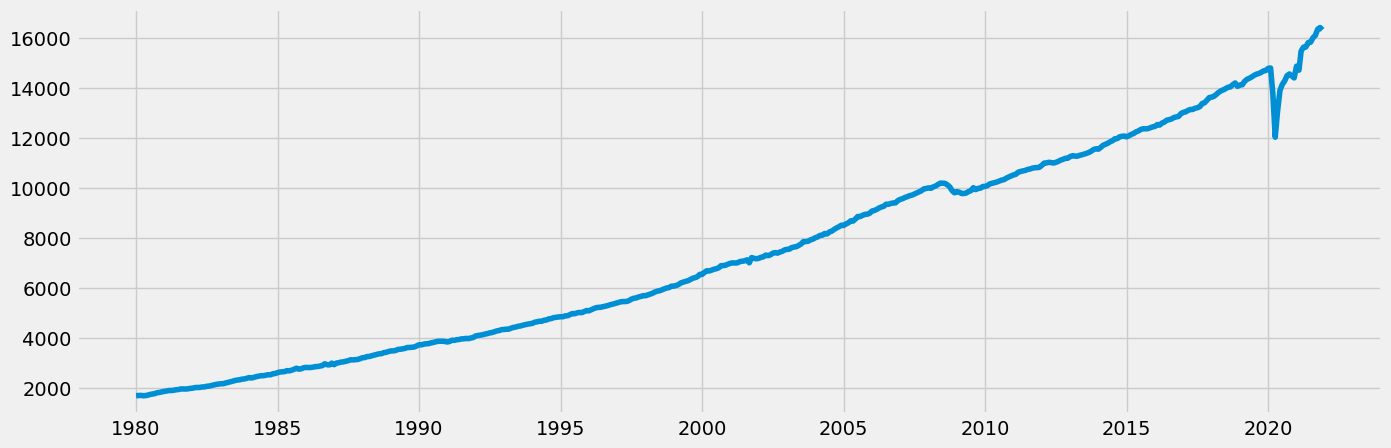

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# 0 dups!

0

### 3. Time-series analysis: decomposition

In [19]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

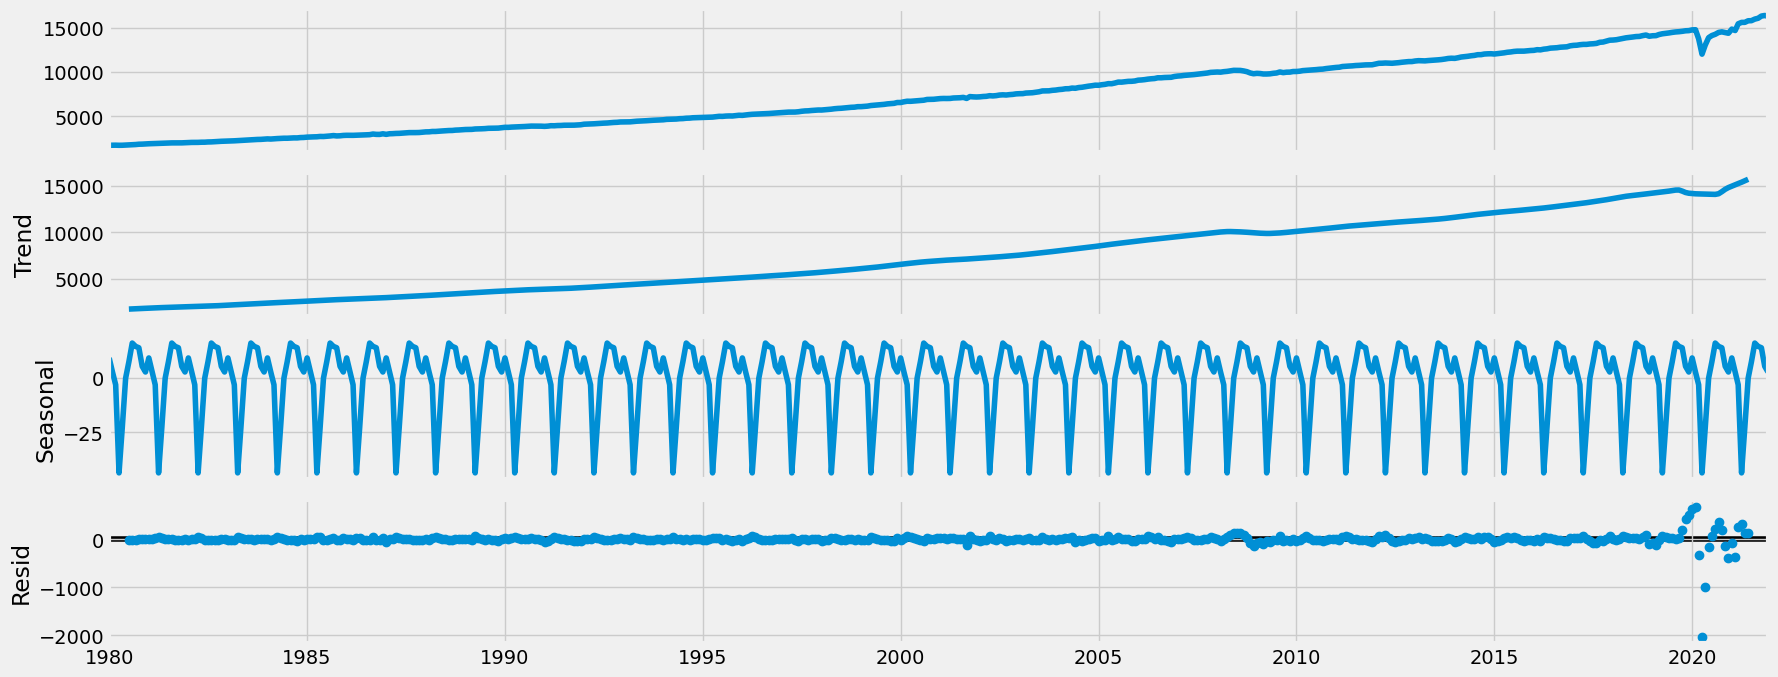

In [21]:
# Plot the separate components

decomposition.plot()
plt.show()

The Trend for Personal Consumption Expenditures has been always on the rise. and the Seasonalty is sinusoidal shape implies that there is a consistent and predictable pattern that repeats at regular intervals.

### 4. Testing for stationarity

In [22]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.646218
p-value                          0.999082
Number of Lags Used             11.000000
Number of Observations Used    492.000000
Critical Value (1%)             -3.443711
Critical Value (5%)             -2.867432
Critical Value (10%)            -2.569908
dtype: float64


With the p-value 0.989959 and the test statistic 0.706112 greater than critical values, we can not reject the null hypothesis. Therefore, based on the Dickey-Fuller test results, we cannot conclude that the time series is stationary.

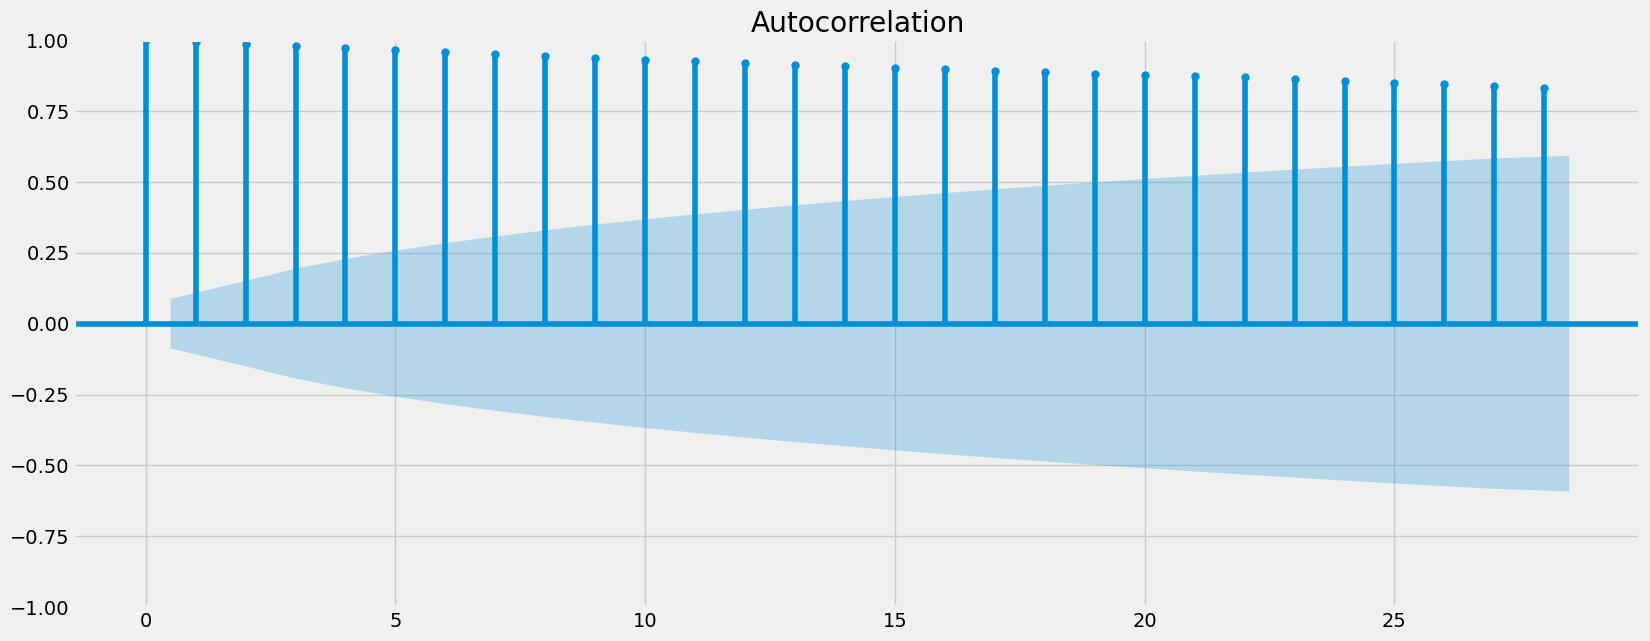

In [23]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

lines go above the blue edge of the confidence interval, this means we have lags that are significantly correlated with each other. And when you have many lags beyond this interval, you can deduce that our data is non-stationary

### 5. Stationarizing the Federal Reserve Economic Data

In [24]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [25]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [26]:
data_diff.head()

,Value
datetime,
1980-02-01,4.1
1980-03-01,6.8
1980-04-01,-13.0
1980-05-01,4.9
1980-06-01,18.7


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

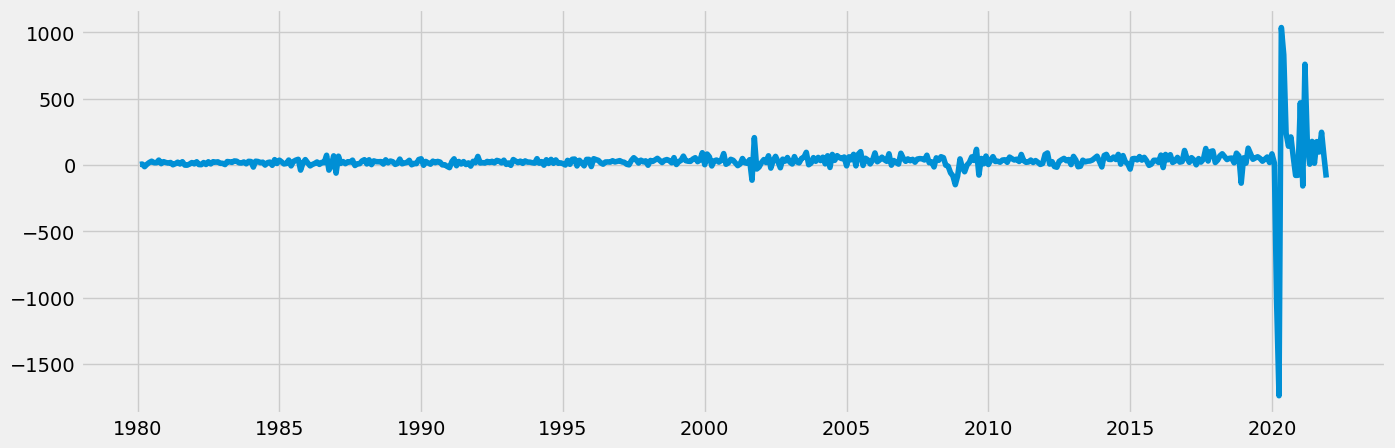

In [28]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.785982e+00
p-value                        2.431593e-09
Number of Lags Used            1.000000e+01
Number of Observations Used    4.920000e+02
Critical Value (1%)           -3.443711e+00
Critical Value (5%)           -2.867432e+00
Critical Value (10%)          -2.569908e+00
dtype: float64


The low p-value and the test statistic falling below the critical values show that the time series is likely stationary.

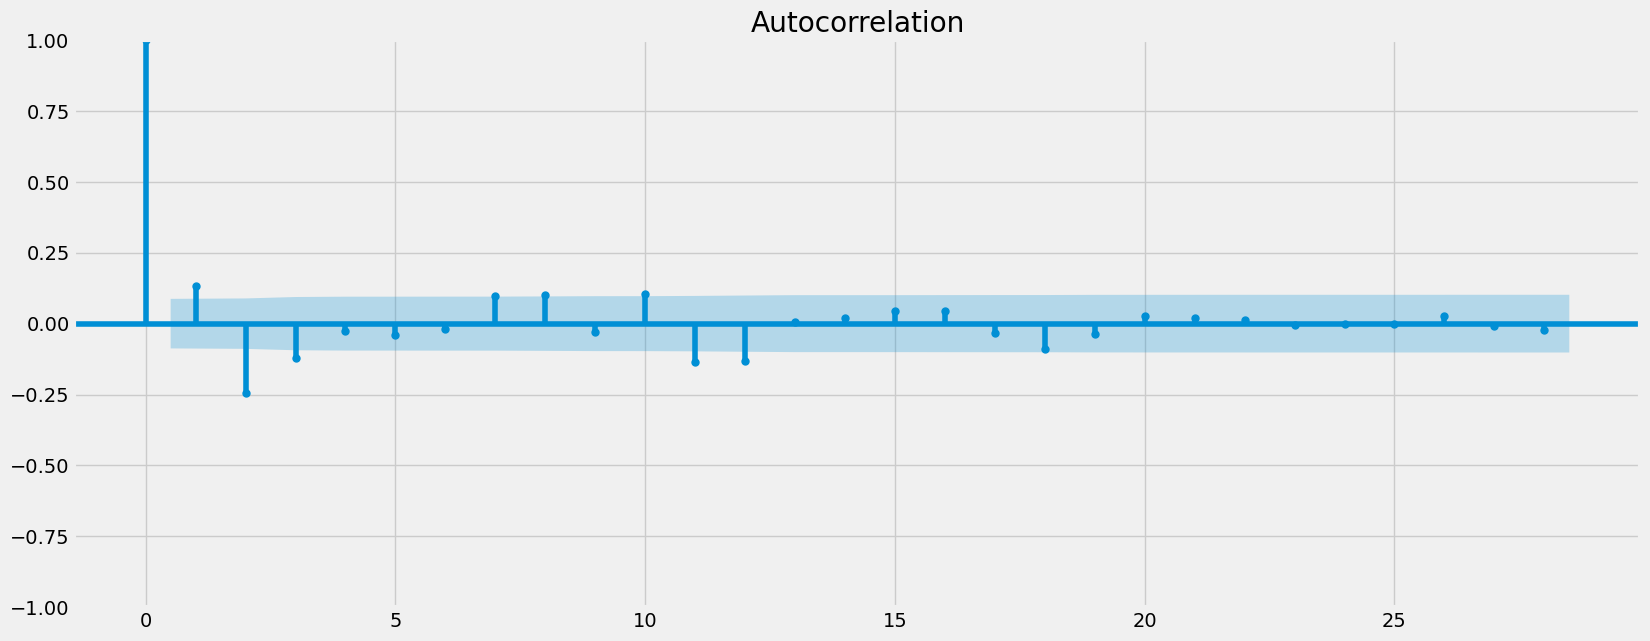

In [30]:
plot_acf(data_diff)
plt.show()

While better than before, there are still couple of lines above the blue confidence interval.
